In [2]:
from typing import Sequence, List
import tushare as ts  # 导入tushare
import pandas as pd
from functional import seq
import toolz as tz
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode(connected=True)

In [3]:
# 设置token
ts.set_token("124da729c44b8186e92d7f7612d856dbef220d30d10f52320e9e433a")

# 初始化pro接口
pro = ts.pro_api()

In [63]:
# 获取每日行情
ts_code = "600809.SH"
df = pro.query("daily", ts_code=ts_code)

In [64]:
# 获取每日指标
df_basic = pro.daily_basic(ts_code=ts_code)

In [65]:
# 数据融合
df = df.merge(df_basic, how="inner", left_on="trade_date", right_on="trade_date")
df = df.sort_values(by="trade_date")
df.head()

,ts_code_x,trade_date,open,high,low,close_x,pre_close,change,pct_chg,vol,...,pe,pe_ttm,pb,ps,ps_ttm,total_share,float_share,free_share,total_mv,circ_mv
3999,600809.SH,20030326,6.57,6.63,6.57,6.63,6.65,-0.02,-0.30,2177.60,...,99.9846,154.8401,3.5939,6.6216,5.9200,43292.4133,7668.4133,7668.4133,287028.7002,50841.5802
3998,600809.SH,20030327,6.58,6.93,6.58,6.91,6.63,0.28,4.22,2999.72,...,104.2072,161.3794,3.7457,6.9013,6.1700,43292.4133,7668.4133,7668.4133,299150.5759,52988.7359
3997,600809.SH,20030328,7.00,7.15,6.94,7.02,6.91,0.11,1.59,16406.65,...,105.8661,163.9484,3.8054,7.0111,6.2682,43292.4133,7668.4133,7668.4133,303912.7414,53832.2614
3996,600809.SH,20030331,7.11,7.22,7.04,7.13,7.02,0.11,1.57,18010.81,...,107.5250,166.5174,3.8650,7.1210,6.3664,43292.4133,7668.4133,7668.4133,308674.9068,54675.7868
3995,600809.SH,20030401,7.18,7.19,7.09,7.14,7.13,0.01,0.14,8514.00,...,107.6758,166.7509,3.8704,7.1310,6.3753,43292.4133,7668.4133,7668.4133,309107.8310,54752.4710


In [36]:
# 保存数据
# df.to_excel("data/600268.xlsx")

In [37]:
# 定义移动平均函数
def calc_mv(s: pd.Series, window: int, *args, **kwargs) -> pd.Series:
    """计算移动平均"""
    return s.rolling(window=window, *args, **kwargs).mean()

In [38]:
# 增加ma5，ma10，ma15，ma20，ma60均线
def add_mv_fields(
        df: pd.DataFrame, 
        close: str, 
        ma_range: Sequence[int]
) -> pd.DataFrame:
    """增加移动平均列"""
    calc_mv_ = lambda x: calc_mv(s=df[close], window=x)
    for i in ma_range:
        df[f"ma{i}"] = calc_mv_(i)
    return df

In [10]:
def add_sigma_fields(
        df: pd.DataFrame,
        short_ma: List[str],
        long_ma: List[str]
) -> pd.DataFrame:
    """增加两个列：
    1）为短期移动平均线计算标准差；
    2）为所有移动平均线计算标准差；
    3）计算1和2差的绝对值
    """
    all_ma = tz.concatv(short_ma, long_ma)
    sigma_for_short = df[short_ma].apply(np.std, axis=1)
    sigma_for_all = df[all_ma].apply(np.std, axis=1)
    sigma_diff = np.abs(sigma_for_all - sigma_for_short)
    df["sigma_for_short"] = sigma_for_short
    df["sigma_for_all"] = sigma_for_all
    df["sigma_diff"] = sigma_diff
    return df

In [11]:
def trans_zscore(df: pd.DataFrame, field: str) -> pd.DataFrame:
    """根据指定列增加一列zscore标准化"""
    seq(df[field].values).accumulate()

In [12]:
def calc_zscore_of_last_elem(s: Sequence[float]) -> float:
    """计算某个序列最后一个元素的zscore"""
    mu = np.mean(s)
    sigma = np.std(s)
    last_elem = s[-1]
    return (last_elem - mu) / sigma

In [13]:
def calc_moving_zscore(s: Sequence[float]) -> Sequence[float]:
    """计算某个序列移动zscore"""
    list_res = list()
    list_to_calc = list()
    for i in range(len(s)):
        if np.isnan(s[i]):
            list_res.append(np.nan)
        else:
            list_to_calc.append(s[i])
            list_res.append(calc_zscore_of_last_elem(list_to_calc))
    return list_res

In [51]:
def add_moving_zscore(df: pd.DataFrame, field: str) -> pd.DataFrame:
    """根据指定的列增加一列移动zscore"""
    df[f"moving_zscore_of_{field}"] = calc_moving_zscore(df[field].values)
    return df

In [27]:
def create_figure(
        df: pd.DataFrame, 
        d: str, 
        o: str, h: str, l: str, c: str, 
        field_subplot: str,
        ma_range: List[str]
):
    """绘图
    * 蜡烛图和移动平均线画在一起
    * 标准化的sigma_diff画在下面
    """
    # 初始化子图
    fig = make_subplots(
        shared_xaxes=True,
        rows=4, cols=1,
        specs=[
            [{"type": "Candlestick", "rowspan": 3}],
            [ None ],
            [ None ],
            [{"type": "Scatter"}]
        ]
    )
    
    # 增加蜡烛图
    fig.add_trace(
        go.Candlestick(
            x=df[d],
            open=df[o],
            high=df[h],
            low=df[l],
            close=df[c]
        ),
        row=1, col=1
    )
    
    # 增加移动平均线
    for i in ma_range:
        fig.add_trace(
            go.Scatter(
                x=df[d],
                y=df[f"ma{i}"],
                mode="lines",
                name=f"ma{i}"
            ),
            row=1, col=1
        )
        
    
    # 增加标准化后的sigma_diff
    fig.add_trace(
        go.Scatter(
            x=df[d],
            y=df[field_subplot],
            mode="lines",
            name="zscore of sigma_diff"
        ),
        row=4, col=1
    )
    
    # 增加x轴范围选择器
    fig.update_layout(xaxis_rangeslider_visible=False)
    
    # show figure
    fig.show()

In [66]:
df = add_mv_fields(df, "close_x", [5, 10, 15, 20, 60])

In [67]:
df2 = add_sigma_fields(df, ["ma5", "ma10", "ma15", "ma20"], ["ma60"])

In [68]:
df3 = add_moving_zscore(df2, "sigma_diff")

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in double_scalars



In [69]:
df3["trade_date"] = pd.to_datetime(df3["trade_date"], format="%Y%m%d")

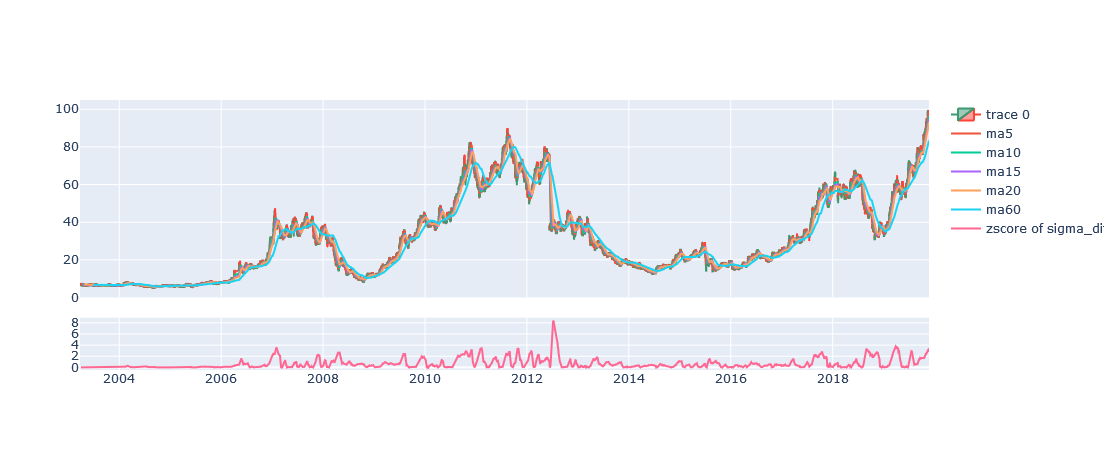

In [70]:
create_figure(
    df3,
    d="trade_date",
    o="open", h="high", l="low", c="close_x",
    field_subplot="sigma_diff",
    ma_range=[5, 10, 15, 20, 60]
)

In [71]:
df3.tail()

,ts_code_x,trade_date,open,high,low,close_x,pre_close,change,pct_chg,vol,...,circ_mv,ma5,ma10,ma15,ma20,ma60,sigma_for_short,sigma_for_all,sigma_diff,moving_zscore_of_sigma_diff
4,600809.SH,2019-11-18,98.00,99.36,95.81,96.62,98.60,-1.98,-2.0081,55865.88,...,8.365826e+06,96.238,93.750,92.636667,90.644,81.569000,2.020366,5.034740,3.014374,2.438947
3,600809.SH,2019-11-19,96.98,98.80,96.62,98.49,96.62,1.87,1.9354,45815.57,...,8.527740e+06,97.214,94.349,93.292667,91.292,82.044500,2.137740,5.163994,3.026254,2.449256
2,600809.SH,2019-11-20,98.70,99.20,97.53,98.70,98.49,0.21,0.2132,30224.70,...,8.545922e+06,98.034,95.149,93.918000,91.982,82.506167,2.196371,5.284547,3.088176,2.511853
1,600809.SH,2019-11-21,98.72,98.85,97.16,98.45,98.70,-0.25,-0.2533,30717.87,...,8.524276e+06,98.172,95.854,94.548000,92.742,82.997333,1.978687,5.240550,3.261863,2.690989
0,600809.SH,2019-11-22,98.70,99.25,92.30,94.49,98.45,-3.96,-4.0223,87603.02,...,8.181400e+06,97.350,96.226,94.648667,93.274,83.395833,1.546495,4.987195,3.440700,2.874813
